### Simulate LP Activity using GBM
* https://medium.com/@chiqing/uniswap-v2-explained-beginner-friendly-b5d2cb64fe0f

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import Image
cwd =  os.getcwd().replace("notebooks/research/impermanent_loss","")
os.chdir(cwd)

from python.dev.cpt import SolveDeltas
from python.dev.math.model import BrownianModel
from python.dev.cpt import Liquidity
from python.dev.cpt import LiquidityPoolUSD
from python.dev.math.model import EventSelectionModel
from python.dev.math.model import TokenDeltaModel

In [2]:
from python.dev.simulation import SimulateLiquidity
from python.dev.simulation import SimLPFees

**Simulate prices**

chg-mu 25.086% chg-sig 10.671%


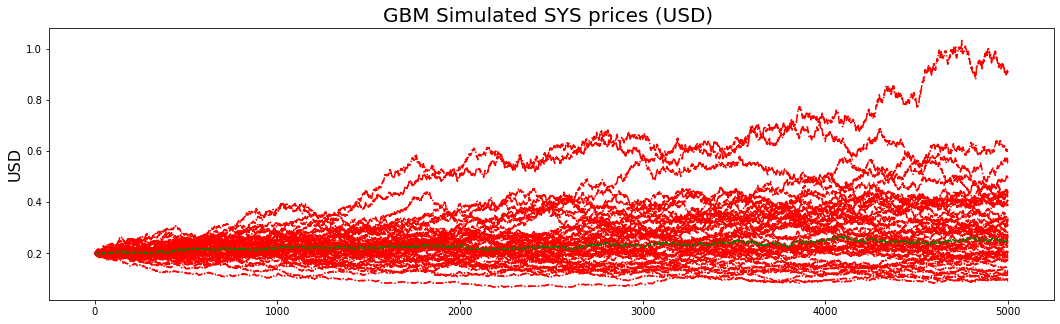

In [64]:
n_steps = 5000
start_price = 0.2
mu = 0.4; sigma = 0.5
n_paths = 50

b = BrownianModel(start_price)
p_arr = b.gen_gbms(mu, sigma, n_steps, n_paths)
exp_p_arr = np.median(p_arr, axis = 1)

x_val = np.arange(0,len(p_arr))
fig, (USD_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(18, 5))
USD_ax.plot(p_arr, color = 'r',linestyle = 'dashdot', label='initial invest') 
USD_ax.plot(exp_p_arr, color = 'g',linestyle = 'dashed', label='initial invest') 
USD_ax.set_title("GBM Simulated SYS prices (USD) ", fontsize=20)
USD_ax.set_ylabel("USD", fontsize=16)

per_chg_sig = 100*np.sqrt(np.var(p_arr))
per_chg_mu = 100*(exp_p_arr[-1]-exp_p_arr[0])/exp_p_arr[0]
print('chg-mu {:.3f}% chg-sig {:.3f}%'.format(per_chg_mu, per_chg_sig))

**Calculate LP holdings using simulated prices**

In [4]:
lp_sims = {}
tdel = TokenDeltaModel(10000) 

for k in range(n_paths):
    liq = Liquidity(100000, 20000, 'SYS','DIA')
    simLiq = SimulateLiquidity(liq, tdel)
    simLiq.run(p_arr[:,k], lp_rate = 0.55)
    #simLiq.run(p_arr[:,k])
    simLiq.check(p_arr[:,k], 1000)
    lp_sims[k] = {}
    lp_sims[k]['sim_liq'] = simLiq  

raw: 0.1889741 y/x: 0.1889736 dy/dx: 0.1886351 liq: 126482.2694760
raw: 0.2175018 y/x: 0.2175004 dy/dx: 0.2165530 liq: 162205.5700775
raw: 0.3122762 y/x: 0.3145607 dy/dx: 0.3125074 liq: 193647.5039966
raw: 0.2769824 y/x: 0.2769805 dy/dx: 0.2757049 liq: 131512.2427451
raw: 0.2335827 y/x: 0.2335839 dy/dx: 0.2343996 liq: 140695.6915630
raw: 0.2309449 y/x: 0.2340370 dy/dx: 0.2419033 liq: 79534.1873667
raw: 0.1876453 y/x: 0.1890508 dy/dx: 0.1926254 liq: 120477.8116817
raw: 0.2859935 y/x: 0.2877626 dy/dx: 0.2846286 liq: 83290.9774168
raw: 0.2522956 y/x: 0.2535595 dy/dx: 0.2575044 liq: 244956.5121459
raw: 0.2182677 y/x: 0.2219653 dy/dx: 0.2189750 liq: 182592.1048679
raw: 0.1360718 y/x: 0.1360735 dy/dx: 0.1371985 liq: 160426.7654179
raw: 0.2221957 y/x: 0.2224338 dy/dx: 0.2219466 liq: 90937.5195335
raw: 0.2062202 y/x: 0.2111491 dy/dx: 0.2106008 liq: 154391.2590987
raw: 0.2273662 y/x: 0.2310071 dy/dx: 0.2333567 liq: 122077.1493571
raw: 0.2834590 y/x: 0.2851762 dy/dx: 0.2863474 liq: 119356.615436

**Determine valuations from LP position**

In [5]:
start_pt = 0
init_pos_sys = 10000
init_pos_dai = p_arr[start_pt,0]*init_pos_sys

for k in range(n_paths):
    simLiq = lp_sims[k]['sim_liq']    
    lp_sims[k]['sys_arr'] = simLiq.get_x_arr()
    lp_sims[k]['dai_arr'] = simLiq.get_y_arr()
    lp_sims[k]['usd_arr'] = simLiq.get_usd_arr()
    
    lpVal = LiquidityPoolUSD(lp_sims[k]['sys_arr'], lp_sims[k]['dai_arr'], p_arr[:,k])
    lp_sims[k]['lp_val'] = lpVal
    lp_sims[k]['hodl_usd'] = lpVal.hodl_position_usd(init_pos_sys, init_pos_dai, start_pt)
    lp_sims[k]['lp_pos'] = lpVal.lp_position_usd(init_pos_sys, init_pos_dai, start_pt)


**Determine collected fees from LP position**

In [6]:
for k in range(n_paths):
    simLiq = lp_sims[k]['sim_liq']
    lpVal = lp_sims[k]['lp_val']
    
    dai_arr = simLiq.get_y_arr()
    
    simFees = SimLPFees(simLiq, lpVal)
    lp_pos_fees = simFees.lp_position_fees_usd(init_pos_sys, init_pos_dai, start_pt)
    percent_returns = simFees.position_percent_returns(init_pos_sys, init_pos_dai, start_pt)
    
    lp_sims[k]['lp_pos_fees'] = lp_pos_fees
    lp_sims[k]['percent_returns'] = percent_returns
    
    print('percent returns: {:.3f}%'.format(100*percent_returns[-1]))
    print('collected fees:  ${:.2f}\n'.format(lp_pos_fees[-1]))
    

percent returns: 4.319%
collected fees:  $172.76

percent returns: 5.887%
collected fees:  $235.47

percent returns: 5.032%
collected fees:  $201.30

percent returns: 6.104%
collected fees:  $244.17

percent returns: 4.604%
collected fees:  $184.14

percent returns: 5.929%
collected fees:  $237.16

percent returns: 5.405%
collected fees:  $216.20

percent returns: 7.220%
collected fees:  $288.80

percent returns: 4.478%
collected fees:  $179.12

percent returns: 3.835%
collected fees:  $153.40

percent returns: 3.287%
collected fees:  $131.50

percent returns: 6.282%
collected fees:  $251.27

percent returns: 4.265%
collected fees:  $170.59

percent returns: 4.826%
collected fees:  $193.03

percent returns: 6.323%
collected fees:  $252.90

percent returns: 5.609%
collected fees:  $224.35

percent returns: 5.404%
collected fees:  $216.15

percent returns: 10.182%
collected fees:  $407.27

percent returns: 5.330%
collected fees:  $213.21

percent returns: 3.556%
collected fees:  $142.24


**Plots**

In [20]:
per_returns = np.zeros((n_steps, n_paths), np.float64)
lp_pos_fees = np.zeros((n_steps, n_paths), np.float64)
lp_pos = np.zeros((n_steps, n_paths), np.float64)
tot_lp_pos = np.zeros((n_steps, n_paths), np.float64)
hodl_usd = np.zeros((n_steps, n_paths), np.float64)
sys_arr = np.zeros((n_steps, n_paths), np.float64)
dai_arr = np.zeros((n_steps, n_paths), np.float64)
usd_arr = np.zeros((n_steps, n_paths), np.float64)
for k in range(0, n_paths):
    per_returns[:,k] = lp_sims[k]['percent_returns']
    lp_pos_fees[:,k] = lp_sims[k]['lp_pos_fees']
    hodl_usd[:,k] = lp_sims[k]['hodl_usd'][1:]
    lp_pos[:,k] = lp_sims[k]['lp_pos'][1:]
    sys_arr[:,k] = lp_sims[k]['sys_arr'][1:]
    dai_arr[:,k] = lp_sims[k]['dai_arr'][1:]
    usd_arr[:,k] = lp_sims[k]['usd_arr'][1:]
    tot_lp_pos[:,k] = lp_pos[:,k] + lp_pos_fees[:,k]

In [21]:
exp_per_returns = np.mean(per_returns, axis = 1)
exp_lp_pos = np.mean(lp_pos, axis = 1)
exp_hodl_usd = np.mean(hodl_usd, axis = 1)
exp_tot_lp_pos = np.mean(tot_lp_pos, axis = 1)
exp_lp_pos_fees = np.mean(lp_pos_fees, axis = 1)

In [22]:
def trading_fees(alpha, t):
    return t*alpha

def imp_loss_v2(per_mu, per_sigma, t, alpha):
    mu = 1*per_mu
    sigma = per_sigma
    return np.exp(-t*(sigma**2)/8 + trading_fees(alpha, t))/np.cosh(mu*t/2) - 1

### Trading Fees: Theoretical vs. Numerical

In [23]:
alpha = np.log(1+exp_per_returns[-1])
theoretical_trade_fees = trading_fees(alpha, 1)
numerical_trade_fees = exp_per_returns[-1]

print('Theoretical trading fees: {:.3f}%'.format(100*theoretical_trade_fees))
print('Numerical trading fees: {:.3f}%'.format(100*numerical_trade_fees))

Theoretical trading fees: 5.480%
Numerical trading fees: 5.633%


### Impermant Loss: Theoretical vs. Numerical

In [24]:
theoretical_IL = imp_loss_v2(mu, sigma, 1, 0)
numerical_IL = (exp_lp_pos[-1] - exp_hodl_usd[-1])/exp_hodl_usd[-1]

print('Theoretical impermanent loss: {:.3f}%'.format(100*theoretical_IL))
print('Numerical impermanent loss: {:.3f}%'.format(100*numerical_IL))

Theoretical impermanent loss: -4.983%
Numerical impermanent loss: -4.552%


### Total Gains: Theoretical vs. Numerical

In [40]:
theoretical_IL = imp_loss_v2(mu, sigma, 1, alpha)
numerical_IL = (exp_tot_lp_pos[-1] - exp_hodl_usd[-1])/exp_hodl_usd[-1]

print('Theoretical gains/losses: {:.3f}%'.format(100*theoretical_IL))
print('Numerical gains/losses: {:.3f}%'.format(100*numerical_IL))

Theoretical gains/losses: 0.369%
Numerical gains/losses: 0.129%


Text(0.5, 0, 'Time')

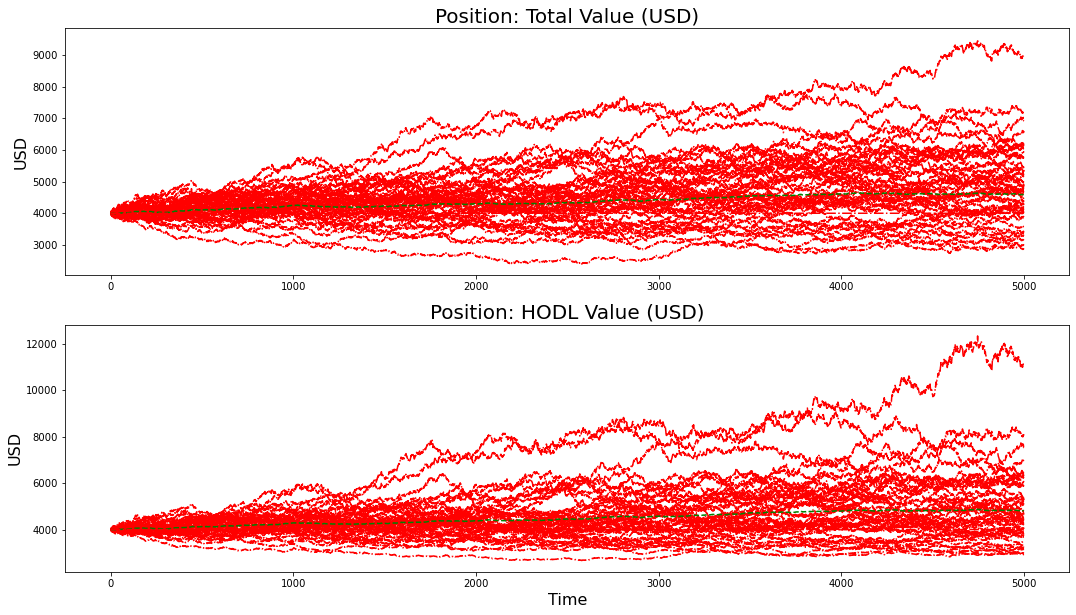

In [61]:
initial_usd = 2*init_pos_dai

fig, (POS_ax, HODL_ax) = plt.subplots(nrows=2, sharex=False, sharey=False, figsize=(18, 10))
POS_ax.plot(tot_lp_pos, color = 'r',linestyle = 'dashdot', label='initial invest') 
POS_ax.plot(exp_lp_pos, color = 'g',linestyle = 'dashed', label='initial invest') 
POS_ax.plot(np.repeat(initial_usd, n_steps), color = 'r',linestyle = 'dashdot', label='initial invest') 
POS_ax.set_title("Position: Total Value (USD)", fontsize=20)
POS_ax.set_ylabel("USD", fontsize=16)

HODL_ax.plot(hodl_usd, color = 'r',linestyle = 'dashdot', label='initial invest') 
HODL_ax.plot(exp_hodl_usd, color = 'g',linestyle = 'dashed', label='initial invest') 
HODL_ax.plot(np.repeat(initial_usd, n_steps), color = 'r',linestyle = 'dashdot', label='initial invest')
HODL_ax.set_title("Position: HODL Value (USD)", fontsize=20)
HODL_ax.set_ylabel("USD", fontsize=16)
HODL_ax.set_xlabel('Time', fontsize=16)


Text(0.5, 0, 'Time')

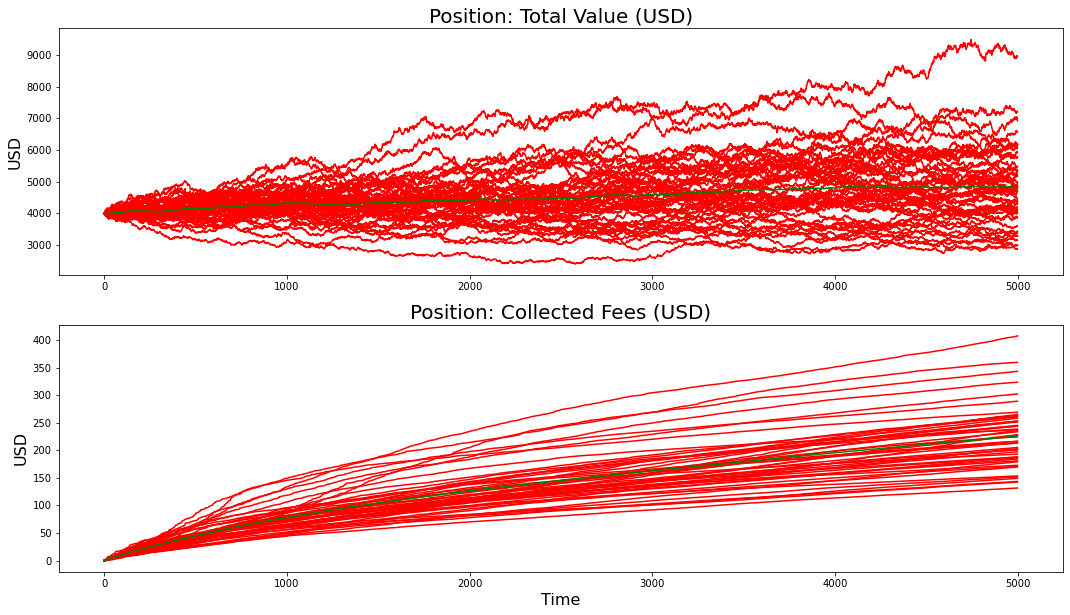

In [50]:
initial_usd = 2*p_arr[0]*init_pos_sys

x_val = np.arange(0,len(p_arr[1:,0]))
fig, (USD_ax, fee_ax) = plt.subplots(nrows=2, sharex=False, sharey=False, figsize=(18, 10))
USD_ax.plot(x_val, tot_lp_pos, color = 'r',label='fees USD') 
USD_ax.plot(x_val, exp_tot_lp_pos, color = 'g',label='fees USD') 
USD_ax.set_title("Position: Total Value (USD)", fontsize=20)
USD_ax.set_ylabel("USD", fontsize=16)

fee_ax.plot(x_val, lp_pos_fees, color = 'r',label='fees USD') 
fee_ax.plot(x_val, exp_lp_pos_fees, color = 'g',label='fees USD')
fee_ax.set_title("Position: Collected Fees (USD)", fontsize=20)
fee_ax.set_ylabel("USD", fontsize=16)
fee_ax.set_xlabel('Time', fontsize=16)


In [ ]:
exp_lp_pos_fees = np.mean(lp_pos_fees, axis = 

Text(0.5, 0, 'Time')

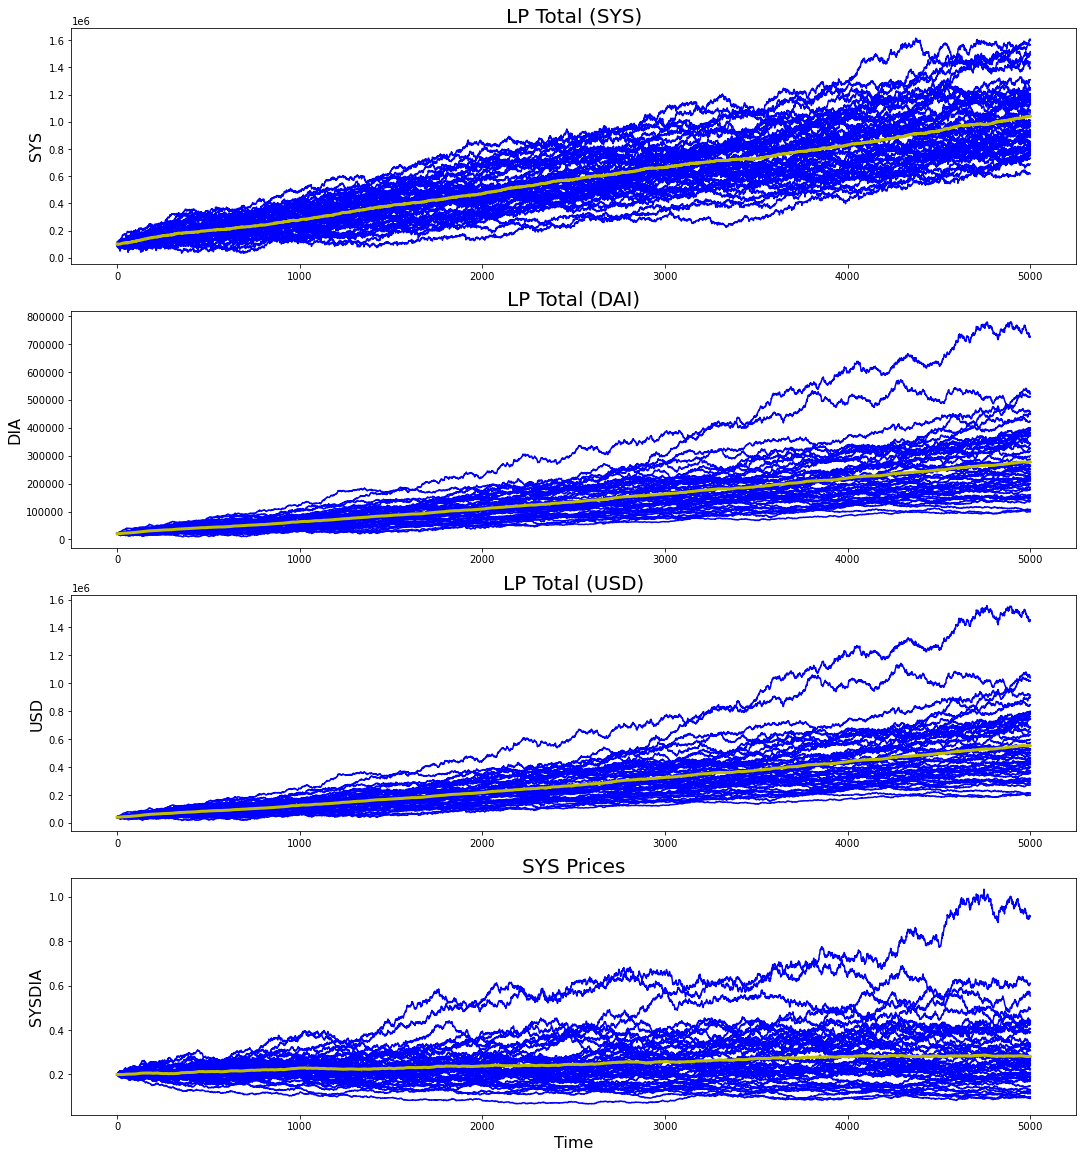

In [58]:
fig, (SYS_ax, DAI_ax, USD_ax, price_ax) = plt.subplots(nrows=4, sharex=False, sharey=False, figsize=(18, 20))
SYS_ax.plot(sys_arr, color = 'b',label='sys') 
SYS_ax.plot(np.mean(sys_arr, axis = 1), color = 'y', linewidth=3, label='exp sys')
SYS_ax.set_title("LP Total (SYS)", fontsize=20)
SYS_ax.set_ylabel("SYS", fontsize=16)

DAI_ax.plot(dai_arr, color = 'b',label='dai') 
DAI_ax.plot(np.mean(dai_arr, axis = 1), color = 'y', linewidth=3, label='exp dai')
DAI_ax.set_title("LP Total (DAI)", fontsize=20)
DAI_ax.set_ylabel("DIA", fontsize=16)

USD_ax.plot(usd_arr, color = 'b',label='usd')
USD_ax.plot(np.mean(usd_arr, axis = 1), color = 'y', linewidth=3, label='exp usd')
USD_ax.set_title("LP Total (USD)", fontsize=20)
USD_ax.set_ylabel("USD", fontsize=16)

price_ax.plot(p_arr, color = 'b', label='price sys') 
price_ax.plot(np.mean(p_arr, axis = 1), color = 'y', linewidth=3, label='price sys')
price_ax.set_title("SYS Prices", fontsize=20)
price_ax.set_ylabel("SYSDIA", fontsize=16)
price_ax.set_xlabel('Time', fontsize=16)
